In [1]:
import torch
import deepwave
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import scipy
import random

from tqdm import tqdm

In [2]:
def normalized_shot_gather(csg):
    max_amp = torch.max(torch.abs(csg), dim=-1, keepdim=True)[0]
    normalized_csg = csg / (max_amp + 1e-10)
    return normalized_csg

In [3]:
offset = 5
src_spacing = 16
n_gp = 24
gp_spacing = 1

x_m = 45
z_m = 20
dx = 0.2

nx = int(x_m/dx)
nz = int(z_m/dx)

In [4]:
shots = torch.tensor([5, 21, 38]).to(device=device)/dx
receiver = torch.arange(10, 34, gp_spacing).to(device=device)/dx

In [5]:
vs_back = 200
vp_back = 500
rho_back = 1800

vs_obs = 3100
vp_obs = 5800
rho_obs =7800

In [6]:
fs = 1000
dt = 1/fs
t= 0.5
nt = int(t/dt)
time = np.arange(0, dt * nt, dt)

In [7]:
x= np.arange(0, x_m, dx)
z= np.arange(0, z_m, dx)
X, Z = np.meshgrid(x, z)

circle_center_x = x_m / 2  # x 중심
circle_center_z = 10  # 깊이 10m
circle_radius = 2.5  # 반지름 5m

# 장애물 영역 계산
circle_mask = (X - circle_center_x) ** 2 + (Z - circle_center_z) ** 2 <= circle_radius ** 2

vp_circle = torch.ones((nz, nx), device=device) * vp_back
vs_circle = torch.ones((nz, nx), device=device) * vs_back
rho_circle = torch.ones((nz, nx), device=device) * rho_back

vp_circle[circle_mask] = vp_obs
vs_circle[circle_mask] = vs_obs
rho_circle[circle_mask] = rho_obs

In [8]:
V_MAX = 3500
V_MIN = 200
data_range = V_MAX - V_MIN

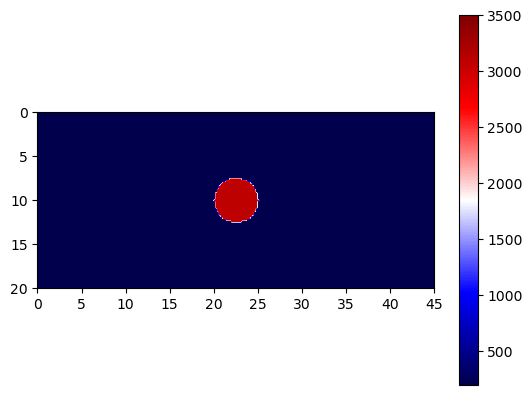

In [9]:
plt.figure()
plt.imshow(vs_circle.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar() 
plt.show()

In [10]:
vp_f, vs_inv, rho_f = torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device), torch.zeros((nz, nx),
                                                                                                              device=device)
vp_f[:, :] = vp_back
vs_inv[:, :] = vs_back
rho_f[:, :] = rho_back

In [11]:
n_shots = len(shots)
n_sources_per_shot = 1

f0 = 20
peak_time = 1.5/f0

source_amplitudes = (
    (deepwave.wavelets.ricker(f0, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

shot = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
shot[..., 0] = 2
shot[..., 1] = (shots).unsqueeze(1)

In [12]:
receiver_locations = torch.zeros(n_shots, len(receiver), 2, dtype=torch.long, device=device)
receiver_locations[..., 0] = 0
receiver_locations[:, :, 1] = receiver

In [13]:
obs = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_circle, vs_circle, rho_circle),
    grid_spacing=dx, dt=dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=shot,
    receiver_locations_y=receiver_locations,
    pml_freq=f0, pml_width=[0, 10, 10, 10]
)[-2]
obs = normalized_shot_gather(obs)

In [14]:
def csg(
    data, receiver, time,
    duration: float,
    title: str,
    color=None,
    second_data=None,
    second_color=None,
    show_legend: bool = True
):
    # numpy 변환
    if hasattr(data, 'detach'):
        data = data.detach().cpu().numpy()
    if second_data is not None and hasattr(second_data, 'detach'):
        second_data = second_data.detach().cpu().numpy()
    if hasattr(receiver, 'detach'):
        receiver = receiver.detach().cpu().numpy()

    dt      = time[1] - time[0]
    max_idx = int(duration / dt)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # 합성파
    for i in range(data.shape[0]):
        trace = data[i, :max_idx]
        norm  = trace / np.max(np.abs(trace))
        ax.plot(receiver[i] + norm, time[:max_idx],
                color=color)

    # 관측파
    if second_data is not None:
        for i in range(second_data.shape[0]):
            trace = second_data[i, :max_idx]
            norm  = trace / np.max(np.abs(trace))
            ax.plot(receiver[i] + norm, time[:max_idx],
                    color=second_color, linestyle='--')

    ax.invert_yaxis()
    ax.set_xlabel("Offset (m)")
    ax.set_ylabel("Time (s)")
    ax.set_title(title)
    if show_legend == True:
        ax.legend(loc='lower right')

    ax.grid(True)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    plt.show()

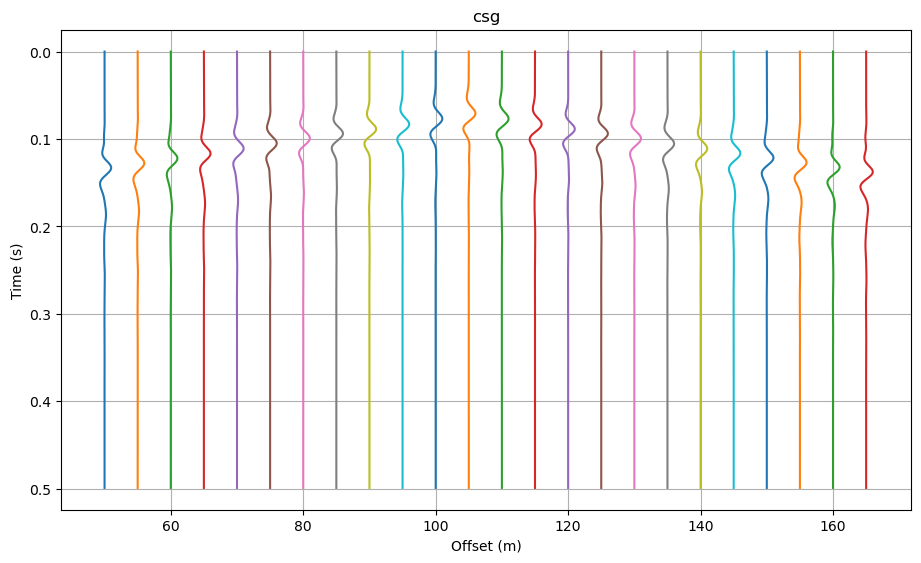

In [15]:
csg(obs[1,:,:], receiver, time, duration = 1, title = "csg", show_legend = False)